In [1]:
import numpy as np
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt

## HMC

In [2]:
def get_action(phi, mu, la):
    return  mu/2 * phi**2 + la/4/3/2 * phi**4

def get_drift(phi, mu, la):
    return - mu * phi - la/3/2 * phi**3

def get_hamiltonian(chi, action):
    return 0.5 * np.sum(chi**2) + action

def mc(phi_0, S_0, mu, la):
    phi = copy.deepcopy(phi_0)
    chi = np.random.randn(*phi.shape)
    H_0 = get_hamiltonian(chi, S_0)

    phi += chi
    S = get_action(phi, mu, la)
    dH = get_hamiltonian(chi, S) - H_0

    if dH > 0:
        if np.random.rand() >= np.exp(-dH):
            return phi_0, S_0, False
    return phi, S, True

def hmc(phi_0, S_0, mu, la, n_steps=100):
    dt = 0.5 / n_steps # Attention! dt is subtle here, should be a little bit large

    phi = copy.deepcopy(phi_0)
    chi = np.random.randn(*phi.shape)
    H_0 = get_hamiltonian(chi, S_0)

    chi += 0.5 * dt * get_drift(phi, mu, la)
    for i in range(n_steps-1):
        phi += dt * chi
        chi += dt * get_drift(phi, mu, la)
    phi += dt * chi
    chi += 0.5 * dt * get_drift(phi, mu, la)

    S = get_action(phi, mu, la)
    dH = get_hamiltonian(chi, S) - H_0

    if dH > 0:
        if np.random.rand() >= np.exp(-dH):
            return phi_0, S_0, False
    return phi, S, True

In [3]:
L = 1
mu = -1.
la = 0.4

In [4]:
cfgs = []
acc = []
therm_step = 16 #16
eq_step = 16
chains = 1024


for chain_idx in tqdm(range(chains)):
    phi = np.random.randn(L)
    S = get_action(phi, mu, la)
    for i in range(therm_step):
        phi, S, accepted = hmc(phi, S, mu, la)
    
    for j in range(eq_step):
            
        phi, S, accepted = hmc(phi, S, mu, la)

        acc.append(accepted)
        
        if j == eq_step -1:
            cfgs.append(copy.deepcopy(phi))

# phi = np.random.randn(L)
# S = get_action(phi, mu, la)
# for i in range(therm_step):
#     phi, S, accepted = hmc(phi, S, mu, la)

# for j in range(chains):
        
#     phi, S, accepted = hmc(phi, S, mu, la)

#     acc.append(accepted)
    
#     if j % eq_step ==1:
#         cfgs.append(copy.deepcopy(phi))


cfgs_hmc = np.array(cfgs)
print(cfgs_hmc.shape)
print(np.array(acc).mean())

100%|██████████| 1024/1024 [00:20<00:00, 50.53it/s]

(1024, 1)
1.0


In [5]:
mag = cfgs_hmc[:,0]
mag_abs = np.abs(mag)
mag_mean = np.mean(mag)
mag_abs_mean = np.mean(mag_abs)
mag_std = np.std(mag)
mag_abs_std = np.std(mag_abs)
print("mag_mean: ", mag_mean)
print("mag_abs_mean: ", mag_abs_mean)

mag_mean:  -0.1842020066925035
mag_abs_mean:  3.425999372726257


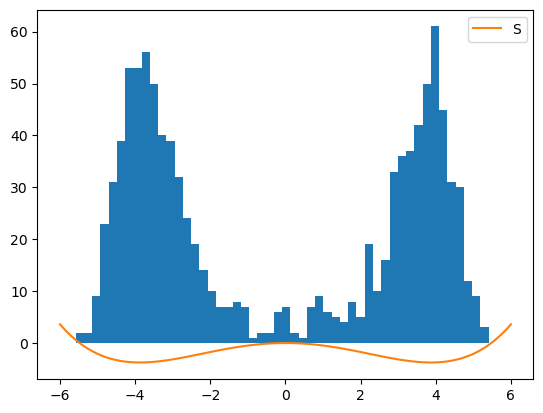

In [6]:
plt.hist(mag,bins=50)

phi = np.linspace(- 6., 6., 100)

plt.plot(phi, get_action(phi,mu,la), label='S')
plt.legend()
plt.show()

## Diffusion model

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

if torch.cuda.is_available():
  device = 'cuda'
  float_dtype = np.float32 # single
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
  device = 'cpu'
  float_dtype = np.float64 # double
  torch.set_default_tensor_type(torch.DoubleTensor)
print(f"Using device: {device}\t" + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU"))

Using device: cpu	CPU


In [30]:
#@title Defining a time-dependent score-based model (double click to expand or collapse)

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""  
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed 
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon DNN architecture."""

  def __init__(self, marginal_prob_std, hidden_nodes= 64, embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.encoder = nn.Linear(1, hidden_nodes)
    self.dense = nn.Linear(embed_dim, hidden_nodes)

    # Decoding layers where the resolution increases
    self.decoder = nn.Linear(hidden_nodes, 1)
    
    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
  
  def forward(self, x, t): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.embed(t))
    # Encoding path
    h = self.encoder(x)

    ## Incorporate information from t
    h += self.dense(embed)
    h = self.act(h)

    # Decoding path
    z = self.decoder(h)
    # z = self.act(z)

    # Normalize output
    z = z / self.marginal_prob_std(t)[:, None]
    return z

In [31]:
def norm(x):
    y = ((x- x.min())/(x.max() - x.min()) - 0.5)*2
    return y, x.min(), x.max()

cfgs_nm,cfgs_min,cfgs_max = norm(cfgs_hmc)

In [32]:
isnorm = 0
if isnorm:
    configs = torch.from_numpy(cfgs_nm).float().to(device) # torch tensor
else:
    configs = torch.from_numpy(cfgs_hmc).float().to(device) # torch tensor

configs.shape
configs.min()

tensor(-6.0581, dtype=torch.float32)

### Training with Weighted Sum of Denoising Score Matching Objectives

Now let's get our hands dirty on training. First of all, we need to specify an SDE that perturbs the data distribution $p_0$ to a prior distribution $p_T$. We choose the following SDE
\begin{align*}
d \mathbf{x} = \sigma^t d\mathbf{w}, \quad t\in[0,1]
\end{align*}
In this case,
\begin{align*}
p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0)) = \mathcal{N}\bigg(\mathbf{x}(t); \mathbf{x}(0), \frac{1}{2\log \sigma}(\sigma^{2t} - 1) \mathbf{I}\bigg)
\end{align*}
and we can choose the weighting function $\lambda(t) = \frac{1}{2 \log \sigma}(\sigma^{2t} - 1)$.

When $\sigma$ is large, the prior distribution, $p_{t=1}$ is 
\begin{align*}
\int p_0(\mathbf{y})\mathcal{N}\bigg(\mathbf{x}; \mathbf{y}, \frac{1}{2 \log \sigma}(\sigma^2 - 1)\mathbf{I}\bigg) d \mathbf{y} \approx \mathbf{N}\bigg(\mathbf{x}; \mathbf{0}, \frac{1}{2 \log \sigma}(\sigma^2 - 1)\mathbf{I}\bigg),
\end{align*}
which is approximately independent of the data distribution and is easy to sample from.

Intuitively, this SDE captures a continuum of Gaussian perturbations with variance function $\frac{1}{2 \log \sigma}(\sigma^{2t} - 1)$. This continuum of perturbations allows us to gradually transfer samples from a data distribution $p_0$ to a simple Gaussian distribution $p_1$.

In [33]:
from torch.utils.data import Dataset, DataLoader,TensorDataset

n_epochs =   200#@param {'type':'integer'}
## size of a mini-batch
batch_size =  256 #@param {'type':'integer'}
## learning rate
lr=1e-4 #@param {'type':'number'} 

dataset = TensorDataset(configs, configs)
data_loader = DataLoader(dataset, batch_size = batch_size, shuffle=True, generator=torch.Generator(device))#

In [34]:
#@title Set up the SDE

import functools

def marginal_prob_std(t, sigma = 25.0):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:    
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.  
  
  Returns:
    The standard deviation.
  """    
  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma = 25.0):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.
  
  Returns:
    The vector of diffusion coefficients.
  """
  return torch.tensor(sigma**t, device=device)
  
sigma =  25.0#@param {'type':'number'} default = 25
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [35]:
#@title Define the loss function (double click to expand or collapse)
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a 
      time-dependent score-based model.
    x: A mini-batch of training data.    
    marginal_prob_std: A function that gives the standard deviation of 
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  # introducing stochasticity for each batch
  z = torch.randn_like(x)
  std = marginal_prob_std(random_t)
  perturbed_x = x + z * std[:, None]
  
  score = model(perturbed_x, random_t)

  loss = torch.mean(torch.sum((score * std[:, None] + z)**2, dim=(1)))
  return loss

In [36]:
#@title Training (double click to expand or collapse)

import torch
import functools
from torch.optim import Adam
import torchvision.transforms as transforms


score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model

In [ ]:
# !jupyter nbextension enable --py widgetsnbextension

n_epochs = 200
from tqdm.notebook import trange, tqdm
optimizer = Adam(score_model.parameters(), lr=lr)
tqdm_epoch = trange(n_epochs, desc="Epochs")

for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0

    for x, y in data_loader:
        x = x.to(device)    
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad()
        loss.backward()    
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]

    # Update the description of the outer tqdm loop with average loss
    tqdm_epoch.set_description('Epoch {:03d}, Average Loss: {:5f}'.format(epoch+1, avg_loss / num_items))
 
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), 'models/dm00_mu{}_la{}_nm{}.pth'.format(mu,la,norm))
    # torch.save(score_model.state_dict(), 'models/ckpt_k{}_L{}.pth'.format(k,L))


### Sampling with Numerical ODE Solvers

For any SDE of the form
\begin{align*}
d \mathbf{x} = \mathbf{f}(\mathbf{x}, t) d t + g(t) d \mathbf{w},
\end{align*}
there exists an associated ordinary differential equation (ODE)
\begin{align*}
d \mathbf{x} = \bigg[\mathbf{f}(\mathbf{x}, t) - \frac{1}{2}g(t)^2 \nabla_\mathbf{x} \log p_t(\mathbf{x})\bigg] dt,
\end{align*}
such that their trajectories have the same mariginal probability density $p_t(\mathbf{x})$. Therefore, by solving this ODE in the reverse time direction, we can sample from the same distribution as solving the reverse-time SDE.
We call this ODE the *probability flow ODE*.

Therefore, we can start from a sample from $p_T$, integrate the ODE in the reverse time direction, and then get a sample from $p_0$. In particular, for the SDE in our running example, we can integrate the following ODE from $t=T$ to $0$ for sample generation
\begin{align*}
d\mathbf{x} =  -\frac{1}{2}\sigma^{2t} s_\theta(\mathbf{x}, t) dt.
\end{align*}
This can be done using many black-box ODE solvers provided by packages such as `scipy`.

In [37]:
#@title Define the ODE sampler (double click to expand or collapse)

from scipy import integrate

## The error tolerance for the black-box ODE solver
error_tolerance = 1e-5 #@param {'type': 'number'}
def ode_sampler(score_model,
                marginal_prob_std,
                diffusion_coeff,
                batch_size=64, 
                atol=error_tolerance, 
                rtol=error_tolerance, 
                device='cpu', 
                z=None,
                eps=1e-3):
  """Generate samples from score-based models with black-box ODE solvers.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that returns the standard deviation 
      of the perturbation kernel.
    diffusion_coeff: A function that returns the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    atol: Tolerance of absolute errors.
    rtol: Tolerance of relative errors.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    z: The latent code that governs the final sample. If None, we start from p_1;
      otherwise, we start from the given z.
    eps: The smallest time step for numerical stability.
  """
  t = torch.ones(batch_size, device=device)
  # Create the latent code
  if z is None:
    init_x = torch.randn(batch_size, 1, device=device) \
      * marginal_prob_std(t)[:, None]
  else:
    init_x = z
  
  shape = init_x.shape

  def score_eval_wrapper(sample, time_steps):
    """A wrapper of the score-based model for use by the ODE solver."""
    sample = torch.tensor(sample, device=device, dtype=torch.float64).reshape(shape)
    time_steps = torch.tensor(time_steps, device=device, dtype=torch.float64).reshape((sample.shape[0], ))    
    with torch.no_grad():    
      score = score_model(sample, time_steps)
    out = score.cpu().numpy().reshape((-1,)).astype(np.float32)
    return out
  
  def ode_func(t, x):        
    """The ODE function for use by the ODE solver."""
    time_steps = np.ones((shape[0],)) * t    
    g = diffusion_coeff(torch.tensor(t)).cpu().numpy().astype(np.float32)
    out =  -0.5 * (g**2) * score_eval_wrapper(x, time_steps)
    return out
  
  # Run the black-box ODE solver.

  res = integrate.solve_ivp(ode_func, (1., eps), init_x.reshape(-1).cpu().numpy().astype(np.float32), rtol=rtol, atol=atol, method='RK45')  
  print(f"Number of function evaluations: {res.nfev}")
  x = torch.tensor(res.y[:, -1], device=device).reshape(shape)

  return x

In [ ]:
`#@title Sampling (double click to expand or collapse)

from torchvision.utils import make_grid

## Load the pre-trained checkpoint from disk.
ckpt = torch.load('models/dm00_mu{}_la{}_nm{}.pth'.format(mu,la,isnorm), map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 1024 #@param {'type':'integer'}
sampler = ode_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

## Generate samples using the specified sampler.
samples = sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)


In [39]:
## Sample visualization.

def renorm(y,xmin,xmax):
    x = (y/2 + 0.5) *(xmax - xmin) + xmin
    return x

# samples_re = samples
samples_re = renorm(samples,cfgs_min,cfgs_max)

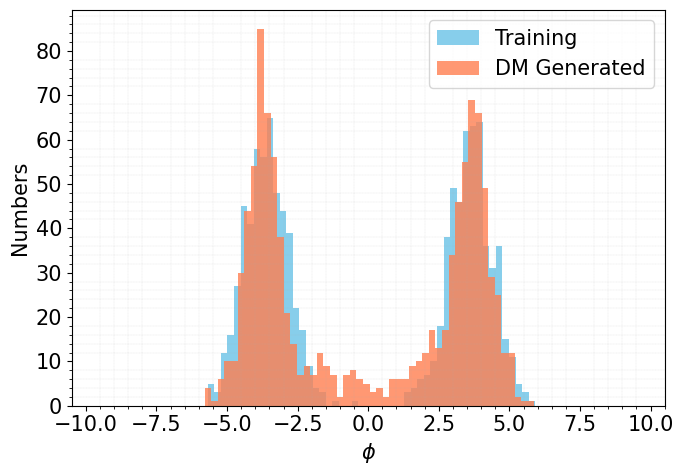

-0.025610059465414968
-0.03267909343189038


In [40]:
%matplotlib inline
import matplotlib.pyplot as plt

def grab(var):
  return var.detach().cpu().numpy()

if isnorm:
  cfgs_df = grab(samples_re)
else:
  cfgs_df = grab(samples)
  
cfgs_df = cfgs_df.squeeze(1)
Mall_df = (cfgs_df)
Mall = (cfgs_hmc)

plt.figure(figsize=(7,5))
plt.rc('font', size=15)
plt.hist(Mall[-sample_batch_size:],bins=50,alpha= 1.,label = 'Training',density=False, color= 'skyblue')
plt.hist(Mall_df,bins=50,alpha = 0.8,label = 'DM Generated',density=False,color='coral')
plt.xlabel(r'$\phi$')
plt.ylabel('Numbers')


plt.xlim([-10.5,10.5])
# plt.ylim([0,80])
plt.legend()
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.2')
plt.tight_layout()

plt.show()
print(Mall.mean())
print(Mall_df.mean())

In [ ]:
score_model(torch.tensor([[0.3]]), torch.tensor([0.1]))

In [ ]:
def drift(phi,mu,la):
    return - mu * phi - la/3/2 * phi**3

N = 100
x = torch.linspace(-10, 10, 500).unsqueeze(-1)  # Discretize the domain
x.requires_grad = True


plt.figure(figsize=(7,5))
colormap = plt.cm.jet_r
# for i in range(N):
#     tau =  torch.Tensor([1/N * (i+1)])
#     Score = score_model(x, tau)[:,0]
#     plt.plot(x.detach().numpy(), Score.detach().numpy(), color = colormap(i/N),alpha = (1-i/N)*0.3)


tau0 =  torch.Tensor([0.01])
Score0 = score_model(x, tau0)[:,0]
plt.plot(x.detach().numpy(), Score0.detach().numpy(), color = 'red',label = r'$\hat{s}_\theta(\phi, \tau = $' + str(1-tau0.item()) + ')' )

tauT =  torch.Tensor([1.])
ScoreT = score_model(x, tauT)[:,0]
plt.plot(x.detach().numpy(), ScoreT.detach().numpy(), color = 'blue',label = r'$\hat{s}_\theta(\phi, \tau = $' + str(1-tauT.item()) + ')')

phi = x.detach().numpy()
plt.plot(phi, drift(phi,mu,la), 'k--', label = r'$f(\phi) =  - \mu^2 \phi - \frac{g}{3!}\phi^3$')

# plt.xlim([-10,10])
plt.ylim([-20,20])

plt.xlabel(r'$\phi$')
plt.ylabel('Drift term')
plt.title(r'$\mu^2 = $' + str(mu) + r', $g = $' + str(la))
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.legend()
plt.tight_layout()

# plt.savefig('figures/dm00_score_mu{}_la{}_nm{}.pdf'.format(mu,la,isnorm))
plt.show()

/var/folders/ps/2fdjqqzs44l8qv1wn99k22s00000gn/T/ipykernel_43532/1302606219.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


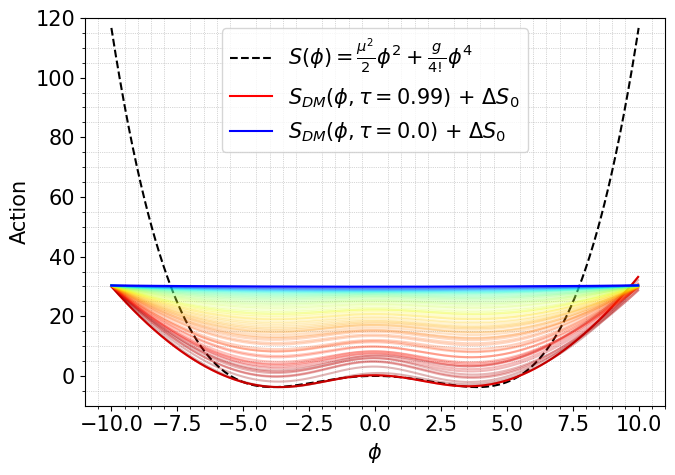

30.31525351279144


In [43]:
def action(phi, mu, la):
    return  mu/2 * phi**2 + la/4/3/2 * phi**4

N = 100
x = torch.linspace(-10.0, 10.0, 1000).unsqueeze(-1)  # Discretize the domain
h = x[1] - x[0]
x.requires_grad = True


def cumulative_integral(Score, x, tau, h):

    cumulative_integrals = h * (0.5 * Score[0] + (Score[:-1] + Score[1:]).cumsum(0) * 0.5)
    return cumulative_integrals


mapping = np.zeros([N, 999]) 

mut = np.zeros(N)
gt = np.zeros(N)
st = np.zeros(N)

plt.figure(figsize=(7,5))
import matplotlib.colors as mcolors
# Create a colormap that transitions from blue to red
# colormap = mcolors.LinearSegmentedColormap.from_list("redBlue", ["red", "blue"])
colormap = plt.cm.jet_r


tau0 =  torch.Tensor([0.01])
Score0 = score_model(x, tau0)[:,0]
Action0 = - cumulative_integral(Score0, x, tau0, h) 

phi = x.detach().numpy()
Phys_Action =  action(phi,mu,la)
plt.plot(phi, Phys_Action, 'k--', label = r'$S(\phi) = \frac{\mu^2}{2}\phi^2 + \frac{g}{4!}\phi^4$')
delta_S = Phys_Action.min() - Action0.min()

Action0 = Action0 + delta_S
plt.plot(x[:-1].detach().numpy(), Action0.detach().numpy(), color = 'red',label = r'$S_{DM}(\phi, \tau = $' + str(1-tau0.item()) + r') + $\Delta S_0$' )

mapping[0,:] = Action0.detach().numpy()

for i in range(N):
    tau =  torch.Tensor([1/N * (i+1)])
    Score = score_model(x, tau)[:,0]
    Action = - cumulative_integral(Score, x, tau, h) + delta_S
    plt.plot(x[:-1].detach().numpy(), Action.detach().numpy(), color = colormap(i/N),alpha = (1-i/N)*0.3)
    mapping[i,:] = Action.detach().numpy()


tauT =  torch.Tensor([1.])
ScoreT = score_model(x, tauT)[:,0]
ActionT = - cumulative_integral(ScoreT, x, tauT, h) + delta_S
plt.plot(x[:-1].detach().numpy(), ActionT.detach().numpy(), color = 'blue',label = r'$S_{DM}(\phi, \tau = $' + str(1-tauT.item()) + r') + $\Delta S_0$' )

mapping[-1,:] = ActionT.detach().numpy()



plt.ylim([-10,120])


plt.xlabel(r'$\phi$')
plt.ylabel('Action')
# plt.title(r'$\mu = $' + str(mu) + r', $g = $' + str(la))


plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.legend()

plt.tight_layout()
plt.show()


print(delta_S.item())

### save gif sfigures

In [44]:
import torch
import matplotlib.pyplot as plt
import imageio
import os

def drift(phi,mu,la):
    return - mu * phi - la/3/2 * phi**3

N = 100
x = torch.linspace(-10, 10, 500).unsqueeze(-1)  # Discretize the domain
x.requires_grad = True

images = []

for i in range(N):
    plt.figure(figsize=(8,6))
    tau =  torch.Tensor([1/N * (N - i)])
    Score = score_model(x, tau)[:,0]  # Assuming score_model is defined
    plt.plot(x.detach().numpy(), Score.detach().numpy(),\
    color = colormap(1/N * (N - i)),label = r'$\hat{s}_\theta(\phi, \tau = $' + str(i/N) + ')',linewidth = 3)
    
    phi = x.detach().numpy()
    plt.plot(phi, drift(phi,mu,la), 'k--', label = r'$f(\phi) =  - \mu^2 \phi - \frac{g}{3!}\phi^3$')
    plt.ylim([-20,20])
    plt.xlabel(r'$\phi$')
    plt.ylabel('Drift term')
    plt.title(r'$\mu^2 = $' + str(mu) + r', $g = $' + str(la))
    plt.minorticks_on()
    plt.grid(which='minor', linestyle=':', linewidth='0.5')
    plt.legend()
    plt.tight_layout()
    
    # Save the current figure to a file
    img_file = 'temp_image_{}.png'.format(i)
    plt.savefig(img_file)
    plt.close()
    images.append(img_file)

# Now create the GIF
imageio.mimsave('dm00_score_mu{}_la{}_nm{}.gif'.format(mu,la,isnorm), [imageio.imread(img_file) for img_file in images])

# Optionally, remove the temporary images
for img_file in images:
    os.remove(img_file)


/var/folders/ps/2fdjqqzs44l8qv1wn99k22s00000gn/T/ipykernel_43532/1302606219.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
/var/folders/ps/2fdjqqzs44l8qv1wn99k22s00000gn/T/ipykernel_43532/3308732716.py:40: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imageio.mimsave('dm00_score_mu{}_la{}_nm{}.gif'.format(mu,la,isnorm), [imageio.imread(img_file) for img_file in images])


In [45]:
import torch
import matplotlib.pyplot as plt
import imageio
import numpy as np
import os


def action(phi, mu, la):
    return mu / 2 * phi**2 + la / 4 / 3 / 2 * phi**4

def cumulative_integral(Score, x, tau, h):
    cumulative_integrals = h * (0.5 * Score[0] + (Score[:-1] + Score[1:]).cumsum(0) * 0.5)
    return cumulative_integrals

N = 100
x = torch.linspace(-10.0, 10.0, 500).unsqueeze(-1)
h = x[1] - x[0]
x.requires_grad = True

images = []  # list to store paths of generated images

for i in range(N):
    plt.figure(figsize=(8,6))
    colormap = plt.cm.jet_r

    tau = torch.Tensor([1/N * (N - i)])
    Score = score_model(x, tau)[:,0]  # Assuming score_model is defined
    Action = - cumulative_integral(Score, x, tau, h) 
    
    phi = x.detach().numpy()
    Phys_Action = action(phi, mu, la)
    plt.plot(phi, Phys_Action, 'k--', label=r'$S(\phi) = \frac{\mu^2}{2}\phi^2 + \frac{g}{4!}\phi^4$')
    
    Action = Action + delta_S
    
    plt.plot(x[:-1].detach().numpy(), Action.detach().numpy(), \
        color=colormap(1/N * (N - i)),label = r'$S_{DM}(\phi, \tau = $' + str(i/N) + r') + $\Delta S_0$',linewidth =3)
    # plt.ylim([-10, 120])

    plt.xlabel(r'$\phi$')
    plt.ylabel('Action')
    plt.minorticks_on()
    plt.grid(which='minor', linestyle=':', linewidth='0.5')
    plt.legend()
    plt.title(r'$\mu^2 = $' + str(mu) + r', $g = $' + str(la))

    plt.tight_layout()
    
    img_file = f'temp_image_{i}.png'
    plt.savefig(img_file)
    plt.close()
    images.append(img_file)

# Create GIF
imageio.mimsave('dm00_action_mu{}_la{}_nm{}.gif'.format(mu,la,isnorm), [imageio.imread(img_file) for img_file in images])

# Optionally, remove the temporary images
for img_file in images:
    os.remove(img_file)


/var/folders/ps/2fdjqqzs44l8qv1wn99k22s00000gn/T/ipykernel_43532/1302606219.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
/var/folders/ps/2fdjqqzs44l8qv1wn99k22s00000gn/T/ipykernel_43532/4275371896.py:55: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imageio.mimsave('dm00_action_mu{}_la{}_nm{}.gif'.format(mu,la,isnorm), [imageio.imread(img_file) for img_file in images])


### plot 3D figures

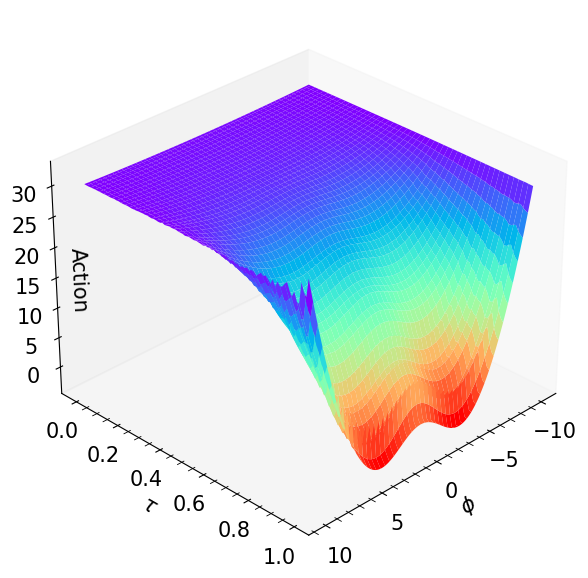

In [44]:
x_np = np.linspace(-10.0, 10.0, 999)
tau = np.linspace(0.01, 1.0, 100)

# 2D grid
X, TAU = np.meshgrid(x_np, 1-tau)

Z = mapping

# 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, TAU, Z, cmap='rainbow_r',antialiased=True)

ax.set_xlabel('$\phi$')
ax.set_ylabel('$\\tau$')
ax.set_zlabel('Action', labelpad=-30)  # 调整z轴标签与轴之间的距离


# viewpoint
ax.view_init(30, 45)
ax.grid(False)
plt.minorticks_on()
plt.tight_layout()

# plt.savefig('figures/dm00_mapping_mu{}_la{}_nm{}.pdf'.format(mu,la,isnorm))


plt.show()

### plot prob density

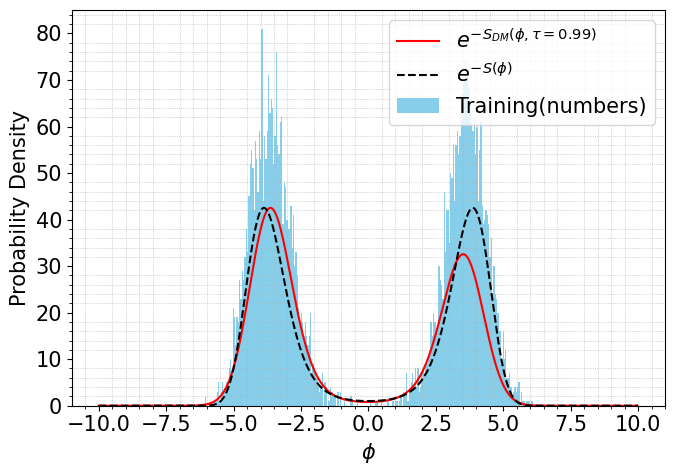

In [54]:
x = torch.linspace(-10.0, 10.0, 1000).unsqueeze(-1)  # Discretize the domain

p0 = np.exp( - Action0.detach().numpy())
p_phy = np.exp( - action(x.detach().numpy(), mu , la))

plt.figure(figsize=(7,5))

plt.plot(x[:-1].detach().numpy(), p0, color = 'red',label = r'$e^{-S_{DM}(\phi, \tau = 0.99)}$' )

plt.plot(x.detach().numpy(), p_phy,  'k--', label = r'$e^{-S(\phi)}$')

plt.hist(Mall,bins=250,alpha= 1.,label = 'Training(numbers)',density=False, color= 'skyblue')
# plt.hist(Mall,bins=250,alpha= 1.,label = 'Training(density)',density=True, color= 'skyblue')

plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.legend(loc='upper right')

plt.xlabel(r'$\phi$')
plt.ylabel('Probability Density')

plt.tight_layout()
plt.savefig('figures/dm00_prob_mu{}_la{}_nm{}.pdf'.format(mu,la,isnorm))


plt.show()

In [ ]:
colormap = plt.cm.jet_r
t = np.linspace(1/N, 1, N)
plt.scatter(mut,gt,s =25, c = t, cmap = colormap,marker='o')
plt.colorbar()

plt.scatter(mu,la,s = 100, c = 'k',marker='*')
plt.xlabel(r'$\mu$')
plt.ylabel(r'$g$')
# plt.plot(mut,gt,'-')
plt.show()